# Optimizing the outflow problem

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import os
import model_helpers
from multiprocesspandas import applyparallel
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from category_encoders import OneHotEncoder
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor


In [2]:
path = '../../data/clean/'
SEED = 12


## Step 0: Naive model (RW)

First, let's load our main dataset with UNCHR covariates and consider the list of countries to make outflow predictions on.

In [3]:
data_outflows = pd.read_csv(path + 'unhcr.csv', engine='pyarrow').drop_duplicates(subset=['Id','year'])[['iso_o', 'year', 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',
       'island_o', 'area_o', 'landlocked_o', 'PR_o', 'CL_o',
        'typeOfViolence_o', 'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o',
        'dead_log_o', 'Nyear_conf_o', 'dead_o', 'newarrival']]

data_outflows['year'] = pd.to_datetime(data_outflows['year'], format='%Y')
data_outflows = pd.concat([data_outflows.drop('newarrival',axis=1).groupby(['iso_o', 'year']).first(),data_outflows.groupby(['iso_o', 'year']).newarrival.sum()],axis=1)
data_outflows = data_outflows.reset_index()
data_outflows["year"] = data_outflows["year"].dt.year

In [4]:
# Rename target column
data_outflows = data_outflows.rename(columns={'newarrival': 'ref_outflow'})

data_outflows.shape


(4900, 19)

In [5]:
# Store the list of countries to predict

iso_3 = data_outflows.iso_o.unique().tolist()

len(iso_3)

196

In [6]:
# Create train/test split
test_time_start = 2018
test_time_end = 2021
train = data_outflows.loc[data_outflows.year < test_time_start]
test = data_outflows.loc[(data_outflows.year >= test_time_start) & (data_outflows.year <= test_time_end)]

In [7]:
y_naive = model_helpers.apply_naive_prediction(train, test, target="ref_outflow", lst_countries=iso_3,
                                              country_var='iso_o'
                                              )


In [8]:
mse_naive = mean_squared_error(y_pred=y_naive, y_true=test.ref_outflow, squared=False)
print("Mse Naive RW: " + str(mse_naive))

Mse Naive RW: 107566.00479382047


In [9]:
data = {
    'iso_o': test.iso_o,
    'year': test.year,
    'y_test': test.ref_outflow,
    'y_naive': y_naive
}
predictions = pd.DataFrame(data)
predictions

,iso_o,year,y_test,y_naive
18,ABW,2018,0.0,1.0
19,ABW,2019,1.0,0.0
20,ABW,2020,0.0,1.0
21,ABW,2021,0.0,0.0
43,AFG,2018,118015.0,128373.0
...,...,...,...,...
4871,ZMB,2021,73.0,86.0
4893,ZWE,2018,1908.0,4523.0
4894,ZWE,2019,3371.0,1908.0
4895,ZWE,2020,1196.0,3371.0


In [10]:
mse_naive_dict = {}

for year in range(2018, 2022):
    data_year = predictions.loc[predictions.year == year]
    mse = mean_squared_error(y_pred=data_year.y_naive, y_true=data_year.y_test, squared=False)
    mse_naive_dict[year] = mse
    print("MSE Naive RW: " + str(mse_naive_dict[year]))


MSE Naive RW: 186457.6701739163
MSE Naive RW: 79332.42279073679
MSE Naive RW: 69270.94242655621
MSE Naive RW: 20572.360390106143


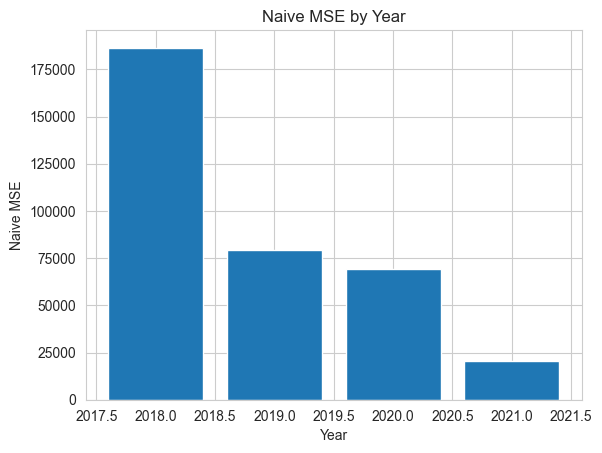

In [11]:
years = mse_naive_dict.keys()
mse_values = mse_naive_dict.values()

plt.bar(years, mse_values)
plt.xlabel('Year')
plt.ylabel('Naive MSE')
plt.title('Naive MSE by Year')
plt.show()


## Step 1: Baseline RF using UNCHR covariates and lags for selected features

In [12]:
data_outflows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   iso_o             4900 non-null   object 
 1   year              4900 non-null   int32  
 2   pop_o             4900 non-null   float64
 3   CPI_o             4900 non-null   float64
 4   GDP_PP_o          4900 non-null   float64
 5   GDP_PPP_o         4900 non-null   float64
 6   island_o          4900 non-null   int64  
 7   area_o            4900 non-null   float64
 8   landlocked_o      4900 non-null   int64  
 9   PR_o              4900 non-null   int64  
 10  CL_o              4900 non-null   int64  
 11  typeOfViolence_o  4900 non-null   int64  
 12  best_est_o        4900 non-null   float64
 13  Nyear_conflict_o  4900 non-null   float64
 14  Nyear_log_o       4900 non-null   float64
 15  dead_log_o        4900 non-null   float64
 16  Nyear_conf_o      4900 non-null   int64  


In [13]:
data_outflows.columns

Index(['iso_o', 'year', 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o', 'island_o',
       'area_o', 'landlocked_o', 'PR_o', 'CL_o', 'typeOfViolence_o',
       'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o', 'dead_log_o',
       'Nyear_conf_o', 'dead_o', 'ref_outflow'],
      dtype='object')

In [14]:
shift_cols_3 = ['ref_outflow','dead_o', 'best_est_o', "dead_log_o"]
shift_cols_2 = [ 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',  'PR_o', 'CL_o', 'Nyear_conflict_o', 'Nyear_log_o', "typeOfViolence_o", "Nyear_conf_o"]



Generating all this lags will cause us to have a bunch of nan values, which we want to avoid to be able to run RF.

I'll impute the first available value to the lag series that are missing with the helper function available in model_helpers.

In [15]:
shifted_df_filled_2 = model_helpers.multi_shift_ffill(data_outflows, shift_cols_2, range(1, 3), 'iso_o', 'year')
shifted_df_filled_3 = model_helpers.multi_shift_ffill(data_outflows, shift_cols_3, range(1, 4), 'iso_o', 'year')

data_outflows_lags = pd.concat([data_outflows, shifted_df_filled_2.reset_index(drop=True).drop(columns=["iso_o", "year"])], axis=1)
data_outflows_lags = pd.concat([data_outflows_lags, shifted_df_filled_3.reset_index(drop=True).drop(columns=["iso_o", "year"])], axis=1)

In [16]:
data_outflows_lags.columns

Index(['iso_o', 'year', 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o', 'island_o',
       'area_o', 'landlocked_o', 'PR_o', 'CL_o', 'typeOfViolence_o',
       'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o', 'dead_log_o',
       'Nyear_conf_o', 'dead_o', 'ref_outflow', 'Shift_1_CPI_o',
       'Shift_1_GDP_PP_o', 'Shift_1_GDP_PPP_o', 'Shift_1_PR_o', 'Shift_1_CL_o',
       'Shift_1_Nyear_conflict_o', 'Shift_1_Nyear_log_o',
       'Shift_1_typeOfViolence_o', 'Shift_1_Nyear_conf_o', 'Shift_2_CPI_o',
       'Shift_2_GDP_PP_o', 'Shift_2_GDP_PPP_o', 'Shift_2_PR_o', 'Shift_2_CL_o',
       'Shift_2_Nyear_conflict_o', 'Shift_2_Nyear_log_o',
       'Shift_2_typeOfViolence_o', 'Shift_2_Nyear_conf_o',
       'Shift_1_ref_outflow', 'Shift_1_dead_o', 'Shift_1_best_est_o',
       'Shift_1_dead_log_o', 'Shift_2_ref_outflow', 'Shift_2_dead_o',
       'Shift_2_best_est_o', 'Shift_2_dead_log_o', 'Shift_3_ref_outflow',
       'Shift_3_dead_o', 'Shift_3_best_est_o', 'Shift_3_dead_log_o'],
      dtype='object')

Apart from lags, we might want to add rolling sums for:
- best estimate for casualties from conflict
- refugee outflows

In [17]:
window_sizes = [4, 6, 11]
group_cols = ['iso_o']
value_cols = ['ref_outflow', 'best_est_o']

panel_data = model_helpers.generate_rolling_sum_variables(data_outflows_lags, group_cols, value_cols, window_sizes, date_col='year')

panel_data

,iso_o,year,pop_o,CPI_o,GDP_PP_o,GDP_PPP_o,island_o,area_o,landlocked_o,PR_o,...,Shift_3_ref_outflow,Shift_3_dead_o,Shift_3_best_est_o,Shift_3_dead_log_o,rolling_sum_past_3_ref_outflow,rolling_sum_past_5_ref_outflow,rolling_sum_past_10_ref_outflow,rolling_sum_past_3_best_est_o,rolling_sum_past_5_best_est_o,rolling_sum_past_10_best_est_o
0,ABW,2000,0.091,3.544,36636.95,0.005,1,193.0,0,4,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,ABW,2001,0.091,2.518,37813.88,0.006,1,193.0,0,5,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,ABW,2002,0.092,4.162,37198.23,0.005,1,193.0,0,3,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,ABW,2003,0.093,2.287,37185.65,0.005,1,193.0,0,3,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,ABW,2004,0.095,2.774,39054.94,0.005,1,193.0,0,3,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4895,ZWE,2020,15.189,348.586,2048.27,0.025,0,390759.0,1,6,...,4523.0,0.0,0.0,0.000000,10998.0,39054.0,301203.0,14.0,14.0,16.0
4896,ZWE,2021,15.492,60.737,2151.97,0.025,0,390759.0,1,6,...,1908.0,0.0,4.0,1.386294,7115.0,21073.0,152453.0,16.0,16.0,18.0
4897,ZWE,2022,15.817,547.255,2171.10,0.025,0,390759.0,1,6,...,3371.0,0.0,8.0,2.079442,5207.0,11638.0,99862.0,14.0,18.0,19.0
4898,ZWE,2023,16.164,100.000,2184.84,0.025,0,390759.0,1,6,...,1196.0,0.0,2.0,0.693147,1836.0,7115.0,78325.0,8.0,20.0,20.0


We generate data for continents

In [18]:
continents = panel_data[['iso_o']].apply(lambda x: model_helpers.mapper(x, model_helpers.country_to_continent)).rename({'iso_o':'iso_o_continent'}, axis=1)
unhcr = pd.concat([continents, panel_data], axis=1)

Finally, we drop the columns that we wouldn't know the value for the same year we are forecasting. That is, we keep only shifted variables and rolling sums, and some descriptive variables (e.g. is island, etc.)

In [19]:
unhcr = unhcr.drop(columns=['CPI_o', 'GDP_PP_o', 'GDP_PPP_o', 'PR_o', 'CL_o',
       'typeOfViolence_o', 'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o',
       'dead_log_o', 'Nyear_conf_o', 'dead_o'])

Binary encoding and scaling

In [20]:
unhcr.columns

Index(['iso_o_continent', 'iso_o', 'year', 'pop_o', 'island_o', 'area_o',
       'landlocked_o', 'ref_outflow', 'Shift_1_CPI_o', 'Shift_1_GDP_PP_o',
       'Shift_1_GDP_PPP_o', 'Shift_1_PR_o', 'Shift_1_CL_o',
       'Shift_1_Nyear_conflict_o', 'Shift_1_Nyear_log_o',
       'Shift_1_typeOfViolence_o', 'Shift_1_Nyear_conf_o', 'Shift_2_CPI_o',
       'Shift_2_GDP_PP_o', 'Shift_2_GDP_PPP_o', 'Shift_2_PR_o', 'Shift_2_CL_o',
       'Shift_2_Nyear_conflict_o', 'Shift_2_Nyear_log_o',
       'Shift_2_typeOfViolence_o', 'Shift_2_Nyear_conf_o',
       'Shift_1_ref_outflow', 'Shift_1_dead_o', 'Shift_1_best_est_o',
       'Shift_1_dead_log_o', 'Shift_2_ref_outflow', 'Shift_2_dead_o',
       'Shift_2_best_est_o', 'Shift_2_dead_log_o', 'Shift_3_ref_outflow',
       'Shift_3_dead_o', 'Shift_3_best_est_o', 'Shift_3_dead_log_o',
       'rolling_sum_past_3_ref_outflow', 'rolling_sum_past_5_ref_outflow',
       'rolling_sum_past_10_ref_outflow', 'rolling_sum_past_3_best_est_o',
       'rolling_sum_past_5_

In [21]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', "Shift_2_typeOfViolence_o"]

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(unhcr.columns) - set(binary_cols  + ['year', 'ref_outflow']))



transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('rf', GradientBoostingRegressor(random_state=SEED))])

In [27]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(unhcr, 'ref_outflow', test_time_start, test_time_end, 'year')

In [28]:
gb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat1', BinaryEncoder(),
                                                  ['iso_o', 'iso_o_continent',
                                                   'Shift_1_typeOfViolence_o',
                                                   'Shift_2_typeOfViolence_o']),
                                                 ('num', RobustScaler(),
                                                  ['Shift_2_CL_o',
                                                   'Shift_1_GDP_PP_o', 'pop_o',
                                                   'rolling_sum_past_10_ref_outflow',
                                                   'Shift_1_CPI_o',
                                                   'Shift_1_dead_o',
                                                   'rolling_sum_past_10_b...
                                                   'rolling_sum_past_5_ref_outflow',
                                                   'Shift_2_dead_o',
                                                   'Shift_2_best_est_o',
                                                   'Shift_1_ref_outflow',
                                                   'Shift_1_Nyear_conflict_o',
                                                   'Shift_2_Nyear_conf_o',
                                                   'rolling_sum_past_3_best_est_o',
                                                   'Shift_2_GDP_PP_o',
                                                   'Shift_3_dead_log_o',
                                                   'rolling_sum_past_3_ref_outflow',
                                                   'Shift_2_dead_log_o',
                                                   'Shift_3_best_est_o', ...])])),
                ('rf', GradientBoostingRegressor(random_state=12))])

In [29]:
y_pred = gb_pipe.predict(X_test)

y_pred = np.clip(y_pred, 0, None)

In [30]:
mse_unhcr = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - UNHCR covariates only: " + str(mse_unhcr))
print("Relative RMSE to Naive predictions: " + str(mse_unhcr/mse_naive))

RMSE outflows - UNHCR covariates only: 81788.94961066614
Relative RMSE to Naive predictions: 0.7603605783020103


In [31]:
predictions["y_unhcr"]=y_pred

### Rolling window

In [32]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(unhcr, 'ref_outflow', test_time_start, test_time_end, 'year')

In [33]:
mse_unhcr_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):

    gb_pipe.fit(X_train, y_train)

    y_pred = gb_pipe.predict(X_test)
    y_pred = np.clip(y_pred, 0, None)
    mse_unhcr_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_unhcr_dict[year] = mse_unhcr_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows - UNHCR covariates: " + str(mse_unhcr_year))
    print("Relative RMSE to Naive predictions: " + str(mse_unhcr_year / mse_naive_dict[year]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_unhcr_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE outflows - UNHCR covariates: 98188.68178542501
Relative RMSE to Naive predictions: 0.5266003897498055
*********
Year: 2019
X_train uses data until: 2018
RMSE outflows - UNHCR covariates: 78348.09123110257
Relative RMSE to Naive predictions: 0.9875923169240566
*********
Year: 2020
X_train uses data until: 2019
RMSE outflows - UNHCR covariates: 69703.57950038336
Relative RMSE to Naive predictions: 1.0062455779966593
*********
Year: 2021
X_train uses data until: 2020
RMSE outflows - UNHCR covariates: 14913.676526040526
Relative RMSE to Naive predictions: 0.7249375493739141


In [34]:
mse_unhcr_dict

{2018: 98188.68178542501,
 2019: 78348.09123110257,
 2020: 69703.57950038336,
 2021: 14913.676526040526}

In [35]:
mse_unhcr_rw = mean_squared_error(y_true=predictions.y_test, y_pred=predictions_df.y_pred_unhcr_rw, squared=False)

print("RMSE outflows - UNHCR covariates only: " + str(mse_unhcr_rw))
print("Relative RMSE to Naive predictions: " + str(mse_unhcr_rw/mse_naive))

RMSE outflows - UNHCR covariates only: 176202.75876414866
Relative RMSE to Naive predictions: 1.638089646463018


## Step 2: Adding Google Trends data

#### Version 1:
+ keywords and topics as downloaded, no dimensionality reduction. 
+ Avg and max per year 
+ rolling sum of the last 3 and 6 months
+ unweighted trends

In [36]:
english_from_topics = pd.read_csv("../trends/data/semantic_keywordsfromtopics_trends_EN.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()
ol_from_topics = pd.read_csv("../trends/data/semantic_keywordsfromtopics_trends_orig_lang.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()
english_boss = pd.read_csv("../trends/data/semantic_keywords_boss_trends_EN.csv").drop_duplicates().drop(columns=["Unnamed: 0"])
ol_boss = pd.read_csv("../trends/data/semantic_keywords_boss_trends_OL.csv").drop_duplicates()

topics = pd.read_csv("../trends/data/semantic_topic_trends_2005.csv").drop(columns=["Unnamed: 0"]).drop_duplicates()
# topics.info() - nulls in country, dropping those
topics = topics[topics.country.isnull()==False]
print(topics.shape)

print(english_from_topics.shape)
# english_boss.info() # A bunch of missing dates - idk what happened there!
# We can't do much without dates so I'm dropping them - will have to check if it's worth re-downloading this 
english_boss = english_boss[english_boss.date.isnull()==False].drop(columns=["index"])
print(english_boss.shape)


# I downloaded data for a maximum of two origin languages. This might not be the best approach, but for now, I'm averaging the values when I have more than one OL.
ol_from_topics_av = ol_from_topics.groupby(['country', 'date']).mean().reset_index()
ol_boss_av = ol_boss.groupby(['country', 'date']).mean().reset_index()
# Print the transformed dataset
print(ol_from_topics_av.shape)
print(ol_boss_av.shape)

C:\Users\danid\AppData\Local\Temp\ipykernel_41716\31775143.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  english_boss = pd.read_csv("../trends/data/semantic_keywords_boss_trends_EN.csv").drop_duplicates().drop(columns=["Unnamed: 0"])


(42098, 8)
(21816, 22)
(12096, 41)
(30240, 22)
(27216, 41)


Big merge:

In [37]:
# Let's merge first keywords - english and OL - separately

english = pd.merge(english_from_topics, english_boss, on=["date", "country"], how="outer")
ol = pd.merge(ol_from_topics_av, ol_boss_av, on=["date", "country"], how="outer")
print(english.shape)
print(ol.shape)

# Get the keywords listed 
keywords = english.columns[~english.columns.isin(['country', 'date'])]
print(keywords)
topics_list = topics.columns[~topics.columns.isin(['country', 'date'])]
print(topics_list)

(24408, 61)
(30240, 61)
Index(['passport', 'Immigration', 'Travel Visa', 'Refugee', 'Conflict', 'War',
       'Violence', 'Crisis', 'Militia', 'Genocide', 'Armed Forces', 'Civilian',
       'Currency', 'Lottery', 'Economy', 'Wage', 'Protest', 'Government',
       'Bureau de change', 'Coup d’état', 'asylum', 'citizen',
       'citizenship+citizenships', 'consulate+consulates', 'crises+crisis',
       'diaspora', 'embassy+embassies', 'emigration', 'foreigner+foreigners',
       'immigrant+immigrants', 'migrate', 'migration',
       'nationality+nationalities', 'recruitment+recruitments',
       'refugee+refugees', 'repatriation', 'Schengen', 'student visa',
       'visa free', 'visa+visas', 'work visa', 'emigrant+emigrants',
       'devaluation', 'immigrate+immigrated',
       'legalization+legalisation+legalisations+legalizations',
       'naturalization+naturalisation+naturalisations+naturalizations',
       'recession+recessions', 'smuggler+smugglers+smuggling',
       'deportation+de

In [38]:
# Create a mapping dictionary for renaming the columns
rename_dict_ol = {var: f"{var}_ol" for var in keywords}
rename_dict_en = {var: f"{var}_en" for var in keywords}
rename_dict_topics = {var: f"{var}_topic" for var in topics_list}
# Rename the columns using the mapping dictionary

english_2 = english.copy()
ol_2 = ol.copy()
topics_2 = topics.copy()

english_2.rename(columns=rename_dict_en, inplace=True)
ol_2.rename(columns=rename_dict_ol, inplace=True)
topics_2.rename(columns=rename_dict_topics, inplace=True)

In [39]:
big_merge = pd.merge(english_2, ol_2, on=["country", "date"], how="outer").merge(topics_2, on=["country", "date"], how="outer")
print(big_merge.shape)
print(big_merge.columns)

(42530, 126)
Index(['date', 'passport_en', 'Immigration_en', 'Travel Visa_en', 'Refugee_en',
       'Conflict_en', 'War_en', 'Violence_en', 'Crisis_en', 'Militia_en',
       ...
       'nationalization+nationalisation_ol', 'asylum seeker_ol',
       'border controls+border control_ol', 'student visa_ol',
       'passport_topic', 'Immigration_topic', 'Travel Visa_topic',
       'Refugee_topic', 'Conflict_topic', 'Economy_topic'],
      dtype='object', length=126)


Average and max values in the year:

In [40]:
avg_trends = big_merge.copy()
avg_trends["iso_o"] = avg_trends["country"].apply(lambda x: model_helpers.convert_iso2_to_iso3(x))
avg_trends.set_index('date', inplace=True)
avg_trends.index = pd.DatetimeIndex(avg_trends.index)
avg_trends = avg_trends.drop(columns=["country"])

# Group by 'iso_o' and resample by YEAR, then mean the values

avg_trends_1 = avg_trends.groupby(['iso_o', pd.Grouper(freq='Y')]).mean().reset_index()
avg_trends_1['year'] = avg_trends_1['date'].dt.year
avg_trends_1 = avg_trends_1.drop(columns=["date"])

# Taking max 

max_trends = avg_trends.groupby(['iso_o', pd.Grouper(freq='Y')]).max().reset_index()
max_trends['year'] = max_trends['date'].dt.year
max_trends = max_trends.drop(columns=["date"])

keywords_new = avg_trends_1.columns[~avg_trends_1.columns.isin(['iso_o', 'year'])]

# Create a mapping dictionary for renaming the columns
rename_dict_avg = {var: f"{var}_avg" for var in keywords_new}
rename_dict_min = {var: f"{var}_min" for var in keywords_new}
rename_dict_max = {var: f"{var}_max" for var in keywords_new}

avg_trends_1.rename(columns=rename_dict_avg, inplace=True)
max_trends.rename(columns=rename_dict_max, inplace=True)

print(avg_trends_1.shape)
print(max_trends.shape)

(3722, 126)
(3722, 126)


In [41]:
avg_trends_1_smoothed = avg_trends_1.apply(model_helpers.smooth_spikes)
max_trends_smoothed = max_trends.apply(model_helpers.smooth_spikes)

Rolling sums (all vars)

In [42]:
# First: monthly aggregation - the data comes monthly automatically when downloading large periods, 
# but because we are not controlling that necessarily during download, just in case

monthly = avg_trends.groupby(['iso_o', pd.Grouper(freq='M')]).mean().reset_index()
monthly['year'] = monthly['date'].dt.year
monthly['month'] = monthly['date'].dt.month
monthly = monthly.drop(columns=["date"])
monthly.shape # it's actually not necessary, same shape

(42530, 127)

In [43]:
final_keywords_list = monthly.columns[~monthly.columns.isin(['year', 'month', 'iso_o'])]
print(final_keywords_list)

Index(['passport_en', 'Immigration_en', 'Travel Visa_en', 'Refugee_en',
       'Conflict_en', 'War_en', 'Violence_en', 'Crisis_en', 'Militia_en',
       'Genocide_en',
       ...
       'nationalization+nationalisation_ol', 'asylum seeker_ol',
       'border controls+border control_ol', 'student visa_ol',
       'passport_topic', 'Immigration_topic', 'Travel Visa_topic',
       'Refugee_topic', 'Conflict_topic', 'Economy_topic'],
      dtype='object', length=124)


In [44]:
window_sizes = [4, 7] # rolling sums for the last 3 and 6 months
group_cols = ['iso_o', 'year']
value_cols = final_keywords_list

panel_trends = model_helpers.generate_rolling_sum_variables(monthly, group_cols, value_cols, window_sizes, date_col='month')

panel_trends = panel_trends[panel_trends["month"]==1]

panel_trends

,iso_o,passport_en,Immigration_en,Travel Visa_en,Refugee_en,Conflict_en,War_en,Violence_en,Crisis_en,Militia_en,...,rolling_sum_past_3_Immigration_topic,rolling_sum_past_6_Immigration_topic,rolling_sum_past_3_Travel Visa_topic,rolling_sum_past_6_Travel Visa_topic,rolling_sum_past_3_Refugee_topic,rolling_sum_past_6_Refugee_topic,rolling_sum_past_3_Conflict_topic,rolling_sum_past_6_Conflict_topic,rolling_sum_past_3_Economy_topic,rolling_sum_past_6_Economy_topic
0,ABW,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,ABW,0.0,0.0,NaN,0.0,18.0,0.0,0.0,60.0,NaN,...,33.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,62.0
24,ABW,0.0,27.0,NaN,42.0,0.0,43.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,23.0,23.0,46.0,46.0,0.0,0.0
36,ABW,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,12.0,12.0,0.0,0.0,22.0,22.0,0.0,0.0,10.0,10.0
48,ABW,0.0,0.0,NaN,0.0,0.0,8.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42481,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,7.0,22.0,22.0,2.0,2.0,8.0,8.0,10.0,10.0
42493,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.0,31.0,31.0,2.0,2.0,8.0,8.0,7.0,7.0
42505,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,12.0,12.0,0.0,0.0,11.0,11.0,8.0,8.0
42517,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,25.0,25.0,2.0,2.0,13.0,13.0,8.0,8.0


In [45]:
trends_final = pd.merge(avg_trends_1_smoothed, max_trends_smoothed, how='outer', on=["iso_o", "year"])
trends_final = pd.merge(trends_final, panel_trends.drop(columns=["month"]), how='outer', on=["iso_o", "year"])
trends_final

,iso_o,passport_en_avg,Immigration_en_avg,Travel Visa_en_avg,Refugee_en_avg,Conflict_en_avg,War_en_avg,Violence_en_avg,Crisis_en_avg,Militia_en_avg,...,rolling_sum_past_3_Immigration_topic,rolling_sum_past_6_Immigration_topic,rolling_sum_past_3_Travel Visa_topic,rolling_sum_past_6_Travel Visa_topic,rolling_sum_past_3_Refugee_topic,rolling_sum_past_6_Refugee_topic,rolling_sum_past_3_Conflict_topic,rolling_sum_past_6_Conflict_topic,rolling_sum_past_3_Economy_topic,rolling_sum_past_6_Economy_topic
0,ABW,23.833333,12.166667,NaN,24.333333,13.416667,9.416667,8.333333,5.250000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ABW,0.000000,0.000000,NaN,1.916667,10.583333,23.583333,4.083333,16.583333,NaN,...,33.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,62.0
2,ABW,2.583333,5.833333,NaN,10.666667,3.416667,16.250000,0.000000,10.583333,NaN,...,0.0,0.0,0.0,0.0,23.0,23.0,46.0,46.0,0.0,0.0
3,ABW,4.333333,3.916667,NaN,5.166667,2.583333,10.666667,4.250000,7.083333,NaN,...,12.0,12.0,0.0,0.0,22.0,22.0,0.0,0.0,10.0,10.0
4,ABW,2.416667,4.333333,NaN,0.000000,2.666667,10.583333,2.250000,5.416667,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3717,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,7.0,22.0,22.0,2.0,2.0,8.0,8.0,10.0,10.0
3718,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,5.0,31.0,31.0,2.0,2.0,8.0,8.0,7.0,7.0
3719,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,12.0,12.0,0.0,0.0,11.0,11.0,8.0,8.0
3720,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,4.0,25.0,25.0,2.0,2.0,13.0,13.0,8.0,8.0


NaN imputation - replace with 0, assuming very low searches/no searches

In [46]:
trends_final = trends_final.fillna(0)

Let's try a first text-based model, without further transformations.

In [47]:
data_outflows_2005 = data_outflows[data_outflows["year"]>=2005]
data_outflows_2005 = data_outflows_2005[["iso_o", "year", "ref_outflow"]]
trends_final_y = pd.merge(trends_final, data_outflows_2005, on=["iso_o", "year"], how="outer")
print(trends_final.shape)
print(trends_final_y.shape) # some trends weren't picked up at all for some countries
trends_final_y = trends_final_y.fillna(0)


(3722, 622)
(3994, 623)


In [48]:
trends_final_y["target"] = trends_final_y.groupby('iso_o').ref_outflow.shift(-1)
trends_final_y = trends_final_y.drop(columns=["ref_outflow"])

In [49]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(trends_final_y.columns) - set(binary_cols  + ['year', 'target']))

from sklearn.compose import ColumnTransformer

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

rf_pipe = Pipeline([('preprocessing', transform_cols),
                    ('rf', RandomForestRegressor(random_state=SEED, n_jobs=-1))])

In [50]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_final_y, 'target', test_time_start, test_time_end, 'year')

In [51]:
rf_pipe.fit(X_train, y_train)


y_pred = rf_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_trends = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends only: " + str(mse_trends))
print("Relative RMSE to Naive predictions: " + str(mse_trends/mse_naive))

RMSE outflows - GTrends only: 110226.15595727545
Relative RMSE to Naive predictions: 1.0247304077952313


Without any historical data, just google trends gives us similar results that the naive model. However, it does seem to hold predictive power.

#### Version 2:

+ keywords and topics as downloaded, no dimensionality reduction. 
+ Avg and max per year 
+ rolling sum of the last 3 and 6 months
+ weighted trends - trends multiplied by population and internet penetration in the country

In [52]:
internet = pd.read_csv("../../data/raw/Internet penetration_WB.csv").drop(columns=["Country Name", "Indicator Name", "Indicator Code"])

In [53]:
value_vars = internet.columns.difference(['Country Code']).tolist()

internet_long = pd.melt(internet, id_vars=['Country Code'], value_vars=value_vars,
                  var_name='year', value_name='internet')
internet_long["year"] = pd.to_datetime(internet_long["year"])
internet_long['year'] = internet_long['year'].dt.year
internet_long = internet_long[internet_long["year"]>=2000]

# Because this has only weighting purpose, I'll fill nans with 1 in the version to multiply
internet_long = internet_long.copy().fillna(1)
internet_long = internet_long.rename(columns={"Country Code":"iso_o"})


In [54]:
data_outflows_2005 = data_outflows[data_outflows["year"]>=2005]
data_outflows_2005 = data_outflows_2005[["iso_o", "year", "ref_outflow", "pop_o"]]
trends_merged = pd.merge(trends_final, data_outflows_2005, on=["iso_o", "year"], how="outer")
trends_merged = pd.merge(trends_merged, internet_long, on=["iso_o", "year"])

# Create a list of variables to weight
variables_to_multiply = [col for col in trends_merged.columns if col not in ['iso_o', 'year', 'pop_o', 'internet', 'ref_outflow']]

# Multiply the variables by 'pop_o' and 'internet'
trends_merged[variables_to_multiply] = trends_merged[variables_to_multiply].multiply(trends_merged['pop_o'], axis=0).multiply(trends_merged['internet'], axis=0)

# Drop non-multiplied variables, 'pop_o', and 'internet'
# columns_to_drop = ['internet', 'pop_o]
# trends_merged.drop(columns=columns_to_drop, inplace=True)

trends_merged = trends_merged.fillna(0)
trends_merged.shape


(3528, 625)

IMPORTANT - I'M GENERATING THE TARGET VARIABLE ALREADY WITH FORECASTING IN MIND (SHIFTED BY 1)

In [55]:
trends_merged["target"] = trends_merged.groupby('iso_o').ref_outflow.shift(-1)
trends_merged = trends_merged.drop(columns=["ref_outflow"])


C:\Users\danid\AppData\Local\Temp\ipykernel_41716\2165611857.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  trends_merged["target"] = trends_merged.groupby('iso_o').ref_outflow.shift(-1)


Applying the same pipeline

In [56]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(trends_merged.columns) - set(binary_cols  + ['year', 'target']))

from sklearn.compose import ColumnTransformer

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

rf_pipe = Pipeline([('preprocessing', transform_cols),
                    ('rf', RandomForestRegressor(random_state=SEED, n_jobs=-1))])

In [57]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [58]:
rf_pipe.fit(X_train, y_train)

y_pred = rf_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_trends_weighted = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends only (weighted): " + str(mse_trends_weighted))
print("Relative RMSE to Naive predictions: " + str(mse_trends_weighted/mse_naive))

RMSE outflows - GTrends only (weighted): 72141.9878119735
Relative RMSE to Naive predictions: 0.6706764646530589


Amazing improvement! 

In [59]:
ind = X_test[["iso_o", "year"]]
ind["y_pred_tw"]=y_pred

predictions = pd.merge(predictions, ind, on=["iso_o", "year"], how="left")

# Compute RMSE for each row
predictions['naive_error'] = np.sqrt((predictions['y_test'] - predictions['y_naive']) ** 2)
predictions['RF_error_trends'] = np.sqrt((predictions['y_test'] - predictions['y_pred_tw']) ** 2)


C:\Users\danid\AppData\Local\Temp\ipykernel_41716\1947740483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_tw"]=y_pred


### Rolling window

In [60]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [61]:
mse_gtrends_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):

    rf_pipe.fit(X_train, y_train)

    y_pred = rf_pipe.predict(X_test)
    y_pred = np.clip(y_pred, 0, None)
    mse_gtrends_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_gtrends_dict[year] = mse_gtrends_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows - gtrends: " + str(mse_gtrends_year))
    print("Relative RMSE to Naive predictions: " + str(mse_gtrends_year / mse_naive_dict[year]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_gtrends_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_trends = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE outflows - gtrends: 112325.73692599352
Relative RMSE to Naive predictions: 0.6024195026207447
*********
Year: 2019
X_train uses data until: 2018
RMSE outflows - gtrends: 26028.34991870142
Relative RMSE to Naive predictions: 0.32809221000799443
*********
Year: 2020
X_train uses data until: 2019
RMSE outflows - gtrends: 36608.0231754412
Relative RMSE to Naive predictions: 0.528475893254296
*********
Year: 2021
X_train uses data until: 2020
RMSE outflows - gtrends: 38967.04207957249
Relative RMSE to Naive predictions: 1.894145413586712


In [62]:
predictions_df = pd.merge(predictions_df, predictions_df_trends, on=["year", "iso_o"], how="outer")


#### Version 3. 

Instead of weighting, I'll try what happens just including pop_o and internet as controls.

In [63]:
# data_outflows_2005 = data_outflows[data_outflows["year"]>=2005]
# data_outflows_2005 = data_outflows_2005[["iso_o", "year", "ref_outflow", "pop_o"]]
# trends_merged = pd.merge(trends_final, data_outflows_2005, on=["iso_o", "year"], how="outer")
# trends_merged = pd.merge(trends_merged, internet_long, on=["iso_o", "year"])

# trends_merged = trends_merged.fillna(0)
# trends_merged.shape


In [64]:
# trends_merged["target"] = trends_merged.groupby('iso_o').ref_outflow.shift(-1)
# trends_merged = trends_merged.drop(columns=["ref_outflow"])

In [65]:
# binary_cols = ['iso_o']

# # numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
# numerical_cols = list(set(trends_merged.columns) - set(binary_cols  + ['year', 'target']))

# from sklearn.compose import ColumnTransformer

# transform_cols = ColumnTransformer(
#     [
#         ('cat1', be, binary_cols),
#    #     ('cat2', ohe, ohe_cols),
#         ('num', cont_scaler, numerical_cols)
#     ],
#     remainder='passthrough'
# )

# rf_pipe = Pipeline([('preprocessing', transform_cols),
#                     ('rf', RandomForestRegressor(n_jobs=-1))])

In [66]:
# X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [67]:
# rf_pipe.fit(X_train, y_train)

# y_pred = rf_pipe.predict(X_test)

# mse_trends_controls = mean_squared_error(y_test, y_pred, squared=False)

# print("RMSE outflows - GTrends only (with controls): " + str(mse_trends_controls))
# print("Relative RMSE to Naive predictions: " + str(mse_trends_controls/mse_naive))

Worse results - going back to the weighted version.

#### Version 4 - Reducing dimensionality

Here I'll use cosine similarity to merge similar keywords and make a model that is faster to train. This is not a problem now, but it will become one when we start adding covariates.

In [68]:
# Preprocess in another notebook

# This might be relevant if the other covariates become too much, but for now it's not necessary to implement

## Step 3. Augmented model: UNHCR covariates + Google Trends

IMPORTANT NOTE ABOUT THE Y: when I first implemented the UNHCR baseline model, I lagged all of the covariates by 1 and dropped the originals.

Here, because I will be merging the UNHCR dataset to the trends dataset, and the trends dataset already has the `target` variable generated considering 1 shift, I will keep the UNHCR covariates as they are (besides considering some lags and rolling sums to add value to the prediction). 

In [69]:
print(trends_merged.shape)

(3528, 625)


In [70]:
shift_cols_3 = ['ref_outflow','dead_o', 'best_est_o', "dead_log_o"]
shift_cols_1 = [ 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',  'PR_o', 'CL_o', 'Nyear_conflict_o', 'Nyear_log_o', "typeOfViolence_o", "Nyear_conf_o"]

shifted_df_filled_1 = model_helpers.multi_shift_ffill(data_outflows, shift_cols_1, range(1, 2), 'iso_o', 'year')
shifted_df_filled_3 = model_helpers.multi_shift_ffill(data_outflows, shift_cols_3, range(1, 4), 'iso_o', 'year')

data_outflows_lags = pd.concat([data_outflows, shifted_df_filled_1.reset_index(drop=True).drop(columns=["iso_o", "year"])], axis=1)
data_outflows_lags = pd.concat([data_outflows_lags, shifted_df_filled_3.reset_index(drop=True).drop(columns=["iso_o", "year"])], axis=1)

window_sizes = [4, 6, 11]
group_cols = ['iso_o']
value_cols = ['ref_outflow', 'best_est_o']

panel_data = model_helpers.generate_rolling_sum_variables(data_outflows_lags, group_cols, value_cols, window_sizes, date_col='year')

continents = panel_data[['iso_o']].apply(lambda x: model_helpers.mapper(x, model_helpers.country_to_continent)).rename({'iso_o':'iso_o_continent'}, axis=1)
unhcr = pd.concat([continents, panel_data], axis=1)

unhcr = unhcr.drop(columns=["ref_outflow"])
len(unhcr.columns)
trends_merged = trends_merged.drop(columns=["pop_o"])

In [71]:
merged_trends_cov = pd.merge(unhcr, trends_merged, on=["iso_o", "year"], how="left")

merged_trends_cov = merged_trends_cov[(merged_trends_cov.year<2022) & (merged_trends_cov.year >2004)]



#selected_rows.shape



In [72]:
merged_trends_cov = merged_trends_cov.fillna(0)
print(merged_trends_cov.shape)
merged_trends_cov.head()

(3332, 668)


,iso_o_continent,iso_o,year,pop_o,CPI_o,GDP_PP_o,GDP_PPP_o,island_o,area_o,landlocked_o,...,rolling_sum_past_3_Travel Visa_topic,rolling_sum_past_6_Travel Visa_topic,rolling_sum_past_3_Refugee_topic,rolling_sum_past_6_Refugee_topic,rolling_sum_past_3_Conflict_topic,rolling_sum_past_6_Conflict_topic,rolling_sum_past_3_Economy_topic,rolling_sum_past_6_Economy_topic,internet,target
5,NA,ABW,2005,0.098,3.787,37910.69,0.005,1,193.0,0,...,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,25.4,0.0
6,NA,ABW,2006,0.099,2.510,37655.07,0.005,1,193.0,0,...,0.0,0.0,0.000,0.000,0.000,0.000,171.864,171.864,28.0,0.0
7,NA,ABW,2007,0.100,9.920,38530.06,0.005,1,193.0,0,...,0.0,0.0,71.070,71.070,142.140,142.140,0.000,0.000,30.9,0.0
8,NA,ABW,2008,0.101,-1.859,38939.16,0.005,1,193.0,0,...,0.0,0.0,115.544,115.544,0.000,0.000,52.520,52.520,52.0,0.0
9,NA,ABW,2009,0.102,6.777,34159.06,0.004,1,193.0,0,...,0.0,0.0,0.000,0.000,53.244,53.244,0.000,0.000,58.0,1.0


In [73]:
#def select_rows_with_nan(data):
 #  return data[data.isnull().any(axis=1)]

#selected_rows = select_rows_with_nan(merged_trends_cov)


In [74]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(merged_trends_cov.columns) - set(binary_cols  + ['year', 'target']))

from sklearn.compose import ColumnTransformer

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('rf', GradientBoostingRegressor(random_state=SEED))])

In [75]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(merged_trends_cov, 'target', test_time_start, test_time_end, 'year')


In [76]:
merged_trends_cov.shape

(3332, 668)

In [77]:
gb_pipe.fit(X_train, y_train)

y_pred = gb_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates: " + str(mse_aug))
print("Relative RMSE to Naive predictions: " + str(mse_aug/mse_naive))

RMSE outflows - GTrends + UNHCR covariates: 66803.54766953754
Relative RMSE to Naive predictions: 0.6210470287297992


In [78]:
ind = X_test[["iso_o", "year"]]
ind["y_pred_aug"]=y_pred

predictions = pd.merge(predictions, ind, on=["iso_o", "year"], how="left")

C:\Users\danid\AppData\Local\Temp\ipykernel_41716\1917419157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_aug"]=y_pred


In [79]:

# Compute RMSE for each row
predictions['GB_error_aug'] = np.sqrt((predictions['y_test'] - predictions['y_pred_aug']) ** 2)
predictions['GB_error_unhcr'] = np.sqrt((predictions['y_test'] - predictions['y_unhcr']) ** 2)

# Define the ranges for grouping the actual values
ranges = [0, 10, 100, 1000,10000,100000, 1200000]  # Modify the ranges as per your requirements
labels = ['0-10', '10-100', '100-1k', '1k-10k','10k-100k','100k+']  # Labels for the groups
# Group the errors based on ranges of actual values
predictions['actual_range'] = pd.cut(predictions['y_test'], ranges, labels=labels, include_lowest=True)



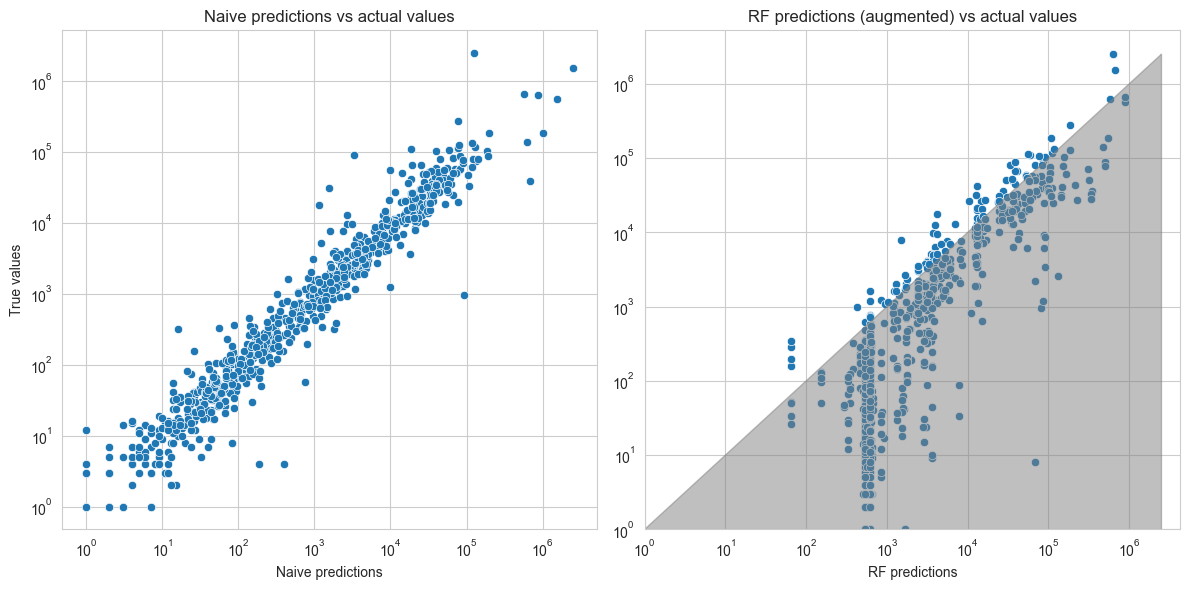

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first subplot
sns.scatterplot(data=predictions, x='y_naive', y='y_test', ax=axes[0])
axes[0].set_xlabel('Naive predictions')
axes[0].set_ylabel('True values')
axes[0].set_title('Naive predictions vs actual values')
axes[0].set_xscale('log')
axes[0].set_yscale('log')


# Plot the second subplot (modify the column names accordingly)
sns.scatterplot(data=predictions, x='y_pred_aug', y='y_test', ax=axes[1])
axes[1].set_xlabel('RF predictions')
axes[1].set_ylabel('')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('RF predictions (augmented) vs actual values')

# Get the maximum value from x and y axes
max_val = max(predictions['y_test'].max(), predictions['y_pred_aug'].max())

# Create the diagonal line coordinates
diagonal_line = np.linspace(0, max_val, 100)

# Fill the area below the diagonal line in the second subplot
axes[1].fill_between(diagonal_line, 0, diagonal_line,
                      where=diagonal_line >= 0,
                      interpolate=True,
                      color='gray', alpha=0.5)
axes[1].set_xlim(left=1)
axes[1].set_ylim(bottom=1)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()




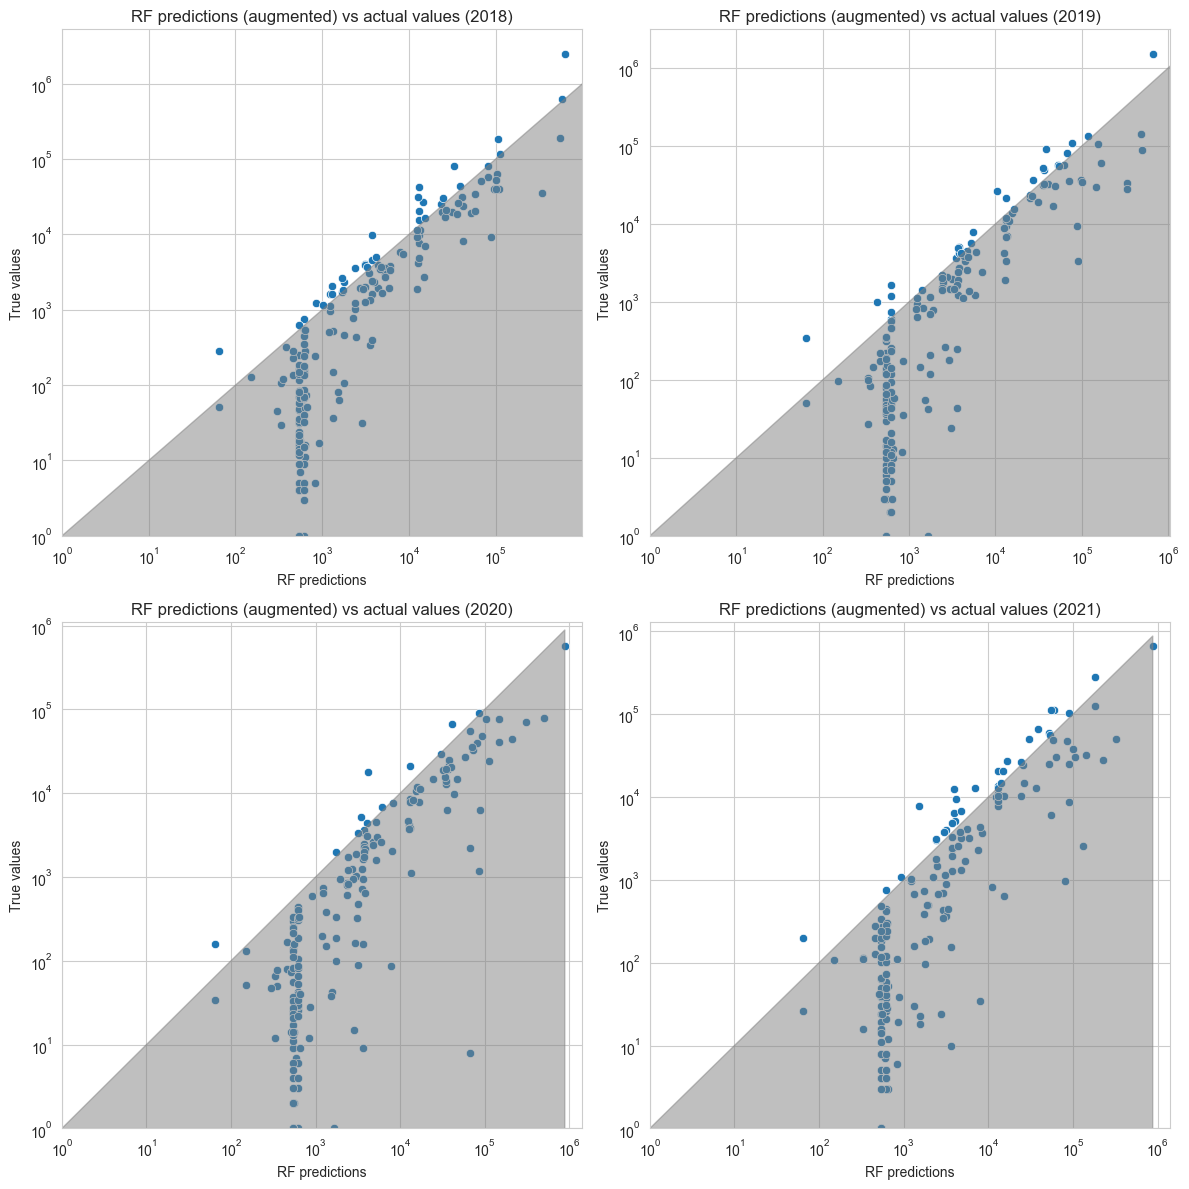

In [81]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

years = predictions['year'].unique()

for i, year in enumerate(years):
    ax = axes.flatten()[i]
    data = predictions[predictions['year'] == year]
    
    # Plot the scatterplot for the current year
    sns.scatterplot(data=data, x='y_pred_aug', y='y_test', ax=ax)
    ax.set_xlabel('RF predictions')
    ax.set_ylabel('True values')
    ax.set_title(f'RF predictions (augmented) vs actual values ({year})')
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Set the lower limits of the x and y axes to 1
    ax.set_xlim(left=1)
    ax.set_ylim(bottom=1)

    # Get the maximum value from x and y axes
    max_val = max(data['y_test'].max(), data['y_pred_aug'].max())

    # Create the diagonal line coordinates
    diagonal_line = np.linspace(0, max_val, 100)

    # Fill the area below the diagonal line in the current subplot
    ax.fill_between(diagonal_line, 0, diagonal_line,
                      where=diagonal_line >= 0,
                      interpolate=True,
                      color='gray', alpha=0.5)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()



In [82]:
# # Hyperparameter tunning
# from sklearn.experimental import enable_halving_search_cv
# from sklearn.model_selection import HalvingGridSearchCV
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid
# param_grid = {
#     'rf__max_features': [0.3, 1, 25, 50, 100, 110, 130, 150, 200, 300, 400],
#     'rf__n_estimators': [50, 100, 120, 150, 200, 300, 350, 400, 500],
#     'rf__max_depth': [None, 3, 5, 10, 15, 16, 17, 20, 25, 30],
#     'rf__random_state': [123]
# }

# # Create the GridSearchCV object
# grid_search = HalvingGridSearchCV(rf_pipe, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# grid_search.fit(X_train, y_train)  

# # Retrieve the best model and its corresponding parameters
# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_

# # Print the best parameters
# print("Best parameters:", best_params)

# y_pred = grid_search.predict(X_test)

# mse_aug_tunned = mean_squared_error(y_test, y_pred, squared=False)

# print("RMSE outflows - GTrends + UNHCR covariates (tunned): " + str(mse_aug_tunned))
# print("Relative RMSE to Naive predictions: " + str(mse_aug_tunned/mse_naive))


## Rolling window

In [83]:
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(merged_trends_cov.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('rf', GradientBoostingRegressor(random_state=SEED))])



In [84]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(merged_trends_cov, 'target', test_time_start, test_time_end, 'year')



In [85]:
mse_aug_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):

    gb_pipe.fit(X_train, y_train)

    y_pred = gb_pipe.predict(X_test)
    y_pred = np.clip(y_pred, 0, None)
    mse_aug_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_aug_dict[year] = mse_aug_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows - aug covariates: " + str(mse_aug_year))
    print("Relative RMSE to Naive predictions: " + str(mse_aug_year / mse_naive_dict[year]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_aug_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_aug = pd.concat(predictions_list, ignore_index=True)


*********
Year: 2018
X_train uses data until: 2017
RMSE outflows - aug covariates: 82681.41526312442
Relative RMSE to Naive predictions: 0.4434326310416957
*********
Year: 2019
X_train uses data until: 2018
RMSE outflows - aug covariates: 47285.518169651055
Relative RMSE to Naive predictions: 0.5960427843528854
*********
Year: 2020
X_train uses data until: 2019
RMSE outflows - aug covariates: 23973.963451896867
Relative RMSE to Naive predictions: 0.34608975440625783
*********
Year: 2021
X_train uses data until: 2020
RMSE outflows - aug covariates: 55143.87282179618
Relative RMSE to Naive predictions: 2.6804835116692054


In [86]:
predictions_df = pd.merge(predictions_df, predictions_df_aug, on=["year", "iso_o"], how="outer")

In [87]:
mse_aug_dict

{2018: 82681.41526312442,
 2019: 47285.518169651055,
 2020: 23973.963451896867,
 2021: 55143.87282179618}

In [88]:
predictions_merged = pd.merge(predictions, predictions_df, on=["iso_o", "year"], how="left")

In [89]:
predictions_merged

,iso_o,year,y_test,y_naive,y_unhcr,y_pred_tw,naive_error,RF_error_trends,y_pred_aug,GB_error_aug,GB_error_unhcr,actual_range,y_pred_unhcr_rw,y_pred_gtrends_rw,y_pred_aug_rw
0,ABW,2018,0.0,1.0,318.862373,3843.63,1.0,3843.63,541.692956,541.692956,318.862373,0-10,318.862373,3843.63,541.692956
1,ABW,2019,1.0,0.0,318.862373,5832.28,1.0,5831.28,541.692956,540.692956,317.862373,0-10,310.223505,25.50,548.913798
2,ABW,2020,0.0,1.0,318.862373,3870.42,1.0,3870.42,541.692956,541.692956,318.862373,0-10,310.863773,47.89,421.040197
3,ABW,2021,0.0,0.0,318.862373,5819.81,0.0,5819.81,541.692956,541.692956,318.862373,0-10,367.454683,24.52,161.939378
4,AFG,2018,118015.0,128373.0,111057.897206,173258.38,10358.0,55243.38,111290.459111,6724.540889,6957.102794,100k+,111057.897206,173258.38,111290.459111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,ZMB,2021,73.0,86.0,339.835089,8435.68,13.0,8362.68,614.659964,541.659964,266.835089,10-100,367.454683,3345.63,161.939378
780,ZWE,2018,1908.0,4523.0,7838.004928,11309.18,2615.0,9401.18,12401.927745,10493.927745,5930.004928,1k-10k,7838.004928,11309.18,12401.927745
781,ZWE,2019,3371.0,1908.0,5029.769920,12378.96,1463.0,9007.96,90809.540343,87438.540343,1658.769920,1k-10k,4875.579362,15866.68,107981.080492
782,ZWE,2020,1196.0,3371.0,8175.404100,8698.71,2175.0,7502.71,85169.669872,83973.669872,6979.404100,1k-10k,10835.110217,13311.91,69294.211483


In [90]:
mean_squared_error(y_true=predictions_merged.y_test, y_pred=predictions_merged.y_pred_aug_rw, squared=False)/mse_naive

0.6866301481141913

In [91]:
# Compute mean RMSE for each group

predictions_merged['RF_error_trends'] = np.sqrt((predictions_merged['y_test'] - predictions_merged['y_pred_tw']) ** 2)
predictions_merged['GB_error_unhcr_rw'] = np.sqrt((predictions_merged['y_test'] - predictions_merged['y_pred_unhcr_rw']) ** 2)
predictions_merged['GB_error_aug_rw'] = np.sqrt((predictions_merged['y_test'] - predictions_merged['y_pred_aug_rw']) ** 2)

grouped_errors = predictions_merged[['naive_error', 'GB_error_unhcr', 'RF_error_trends', 'GB_error_aug', 'GB_error_unhcr_rw', 'GB_error_aug_rw', 'actual_range']].groupby('actual_range').mean()
grouped_errors

,naive_error,GB_error_unhcr,RF_error_trends,GB_error_aug,GB_error_unhcr_rw,GB_error_aug_rw
actual_range,,,,,,
0-10,10.247788,318.257378,2075.058119,1248.398968,332.997383,768.913606
10-100,23.441176,287.391335,3126.126853,757.485419,291.419354,470.599205
100-1k,709.000000,495.810252,19687.648046,1403.062459,462.021937,1184.759108
1k-10k,1628.398907,3217.457362,16662.632049,6855.337172,2961.712716,5635.990034
10k-100k,20092.700787,32608.392873,31534.464370,41104.938357,22212.295540,23191.235790
100k+,213039.666667,279812.069090,189711.664000,115443.320459,206497.239316,73795.804623


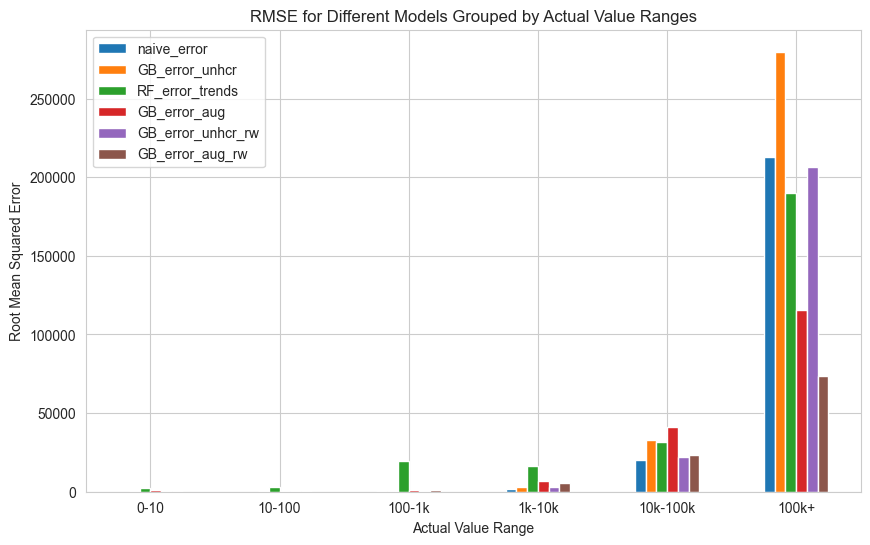

In [92]:
grouped_errors.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
# plt.yscale('log')
plt.legend()
plt.show()

In [93]:
# Calculate the mean for each column
#p = predictions_merged[['naive_error', 'GB_error_unhcr', 'RF_error_trends', 'GB_error_aug', 
 #                                    'GB_error_unhcr_rw', 'RF_error_trends_rw', 'GB_error_aug_rw']]

# columns = p.columns
# predictions_merged = predictions_merged.dropna()
mse_1 = mean_squared_error(predictions_merged.y_test, predictions_merged.y_naive, squared=False)
mse_2 = mean_squared_error(predictions_merged.y_test, predictions_merged.y_unhcr, squared=False)

mse_4 = mean_squared_error(predictions_merged.y_test, predictions_merged.y_pred_aug, squared=False)
mse_5 = mean_squared_error(predictions_merged.y_test, predictions_merged.y_pred_unhcr_rw, squared=False)
mse_6 = mean_squared_error(predictions_merged.y_test, predictions_merged.y_pred_aug_rw, squared=False)

print("1) RMSE Naive: " + str(mse_1))
print("2) RMSE UNHCR covs (gb): " + str(mse_2))
print("4) RMSE UNHCR + Gtrends (gb): " + str(mse_4))
print("5) RMSE UNHCR covs (rolling window): " + str(mse_5))
print("6) RMSE UNHCR + Gtrends (rolling window): " + str(mse_6))

print("**********")

print("1) Rel RMSE Naive: " + str(mse_1/mse_1))
print("2) Rel RMSE UNHCR covs (gb): " + str(mse_2/mse_1))
print("4) Rel RMSE UNHCR + Gtrends (gb): " + str(mse_4/mse_1))
print("5) Rel RMSE UNHCR covs (rolling window): " + str(mse_5/mse_1))
print("6) Rel RMSE UNHCR + Gtrends (rolling window): " + str(mse_6/mse_1))


1) RMSE Naive: 107566.00479382047
2) RMSE UNHCR covs (gb): 81788.94961066614
4) RMSE UNHCR + Gtrends (gb): 85489.39114768317
5) RMSE UNHCR covs (rolling window): 72215.73127270515
6) RMSE UNHCR + Gtrends (rolling window): 73858.06180363277
**********
1) Rel RMSE Naive: 1.0
2) Rel RMSE UNHCR covs (gb): 0.7603605783020103
4) Rel RMSE UNHCR + Gtrends (gb): 0.7947621677643124
5) Rel RMSE UNHCR covs (rolling window): 0.6713620293988445
6) Rel RMSE UNHCR + Gtrends (rolling window): 0.6866301481141913


## Step 4. Augmented model + extra covariates

#### MIGRATION


In [94]:

migration = pd.read_csv(path + 'migration_stocks.csv')

migration = migration.groupby(['iso_o', 'year'])['migration_stock'].sum().reset_index()

migration['migration_change'] = migration.groupby('iso_o')['migration_stock'].pct_change() * 100

migration = migration.fillna(0)


In [95]:
aug_1 = pd.merge(merged_trends_cov, migration, on=["iso_o", "year"], how="left")
print(migration.shape)
print(aug_1.shape)
print(merged_trends_cov.shape)
aug_1["migration_stock_weighted"] = aug_1["migration_stock"]/aug_1["pop_o"]

(4900, 4)
(3332, 670)
(3332, 668)


C:\Users\danid\AppData\Local\Temp\ipykernel_41716\1238760211.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aug_1["migration_stock_weighted"] = aug_1["migration_stock"]/aug_1["pop_o"]


In [96]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(aug_1.columns) - set(binary_cols  + ['year', 'target']))

from sklearn.compose import ColumnTransformer

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])



In [97]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_1, 'target', test_time_start, test_time_end, 'year')


gb_pipe.fit(X_train, y_train)

y_pred = gb_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug_1 = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + Migration: " + str(mse_aug_1))
print("Relative RMSE to Naive predictions: " + str(mse_aug_1/mse_naive))

RMSE outflows - GTrends + UNHCR covariates + Migration: 64999.60257609399
Relative RMSE to Naive predictions: 0.6042764412481753


Some improvement :) Migration features are not super important but they still improve the model.

In [98]:
ind = X_test[["iso_o", "year"]]
ind["y_pred_aug_mig"]=y_pred

predictions_merged = pd.merge(predictions_merged, ind, on=["iso_o", "year"], how="left")


# Compute RMSE for each row

predictions_merged['GB_error_aug_mig'] = np.sqrt((predictions_merged['y_test'] - predictions_merged['y_pred_aug_mig']) ** 2)

C:\Users\danid\AppData\Local\Temp\ipykernel_41716\3799190907.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_aug_mig"]=y_pred


### Rolling window

In [99]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(aug_1, 'target', test_time_start, test_time_end, 'year')

In [100]:
mse_mig_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):

    gb_pipe.fit(X_train, y_train)

    y_pred = gb_pipe.predict(X_test)
    y_pred = np.clip(y_pred, 0, None)
    mse_mig_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_mig_dict[year] = mse_mig_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows - migration covariates: " + str(mse_mig_year))
    print("Relative RMSE to Naive predictions: " + str(mse_mig_year / mse_naive_dict[year]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_mig_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_mig = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE outflows - migration covariates: 82786.77313453131
Relative RMSE to Naive predictions: 0.4439976808533158
*********
Year: 2019
X_train uses data until: 2018
RMSE outflows - migration covariates: 50011.34655785398
Relative RMSE to Naive predictions: 0.6304023600763335
*********
Year: 2020
X_train uses data until: 2019
RMSE outflows - migration covariates: 25833.0742912742
Relative RMSE to Naive predictions: 0.37292800395582093
*********
Year: 2021
X_train uses data until: 2020
RMSE outflows - migration covariates: 72970.32805860377
Relative RMSE to Naive predictions: 3.5470080571647657


In [101]:
predictions_merged_2 = pd.merge(predictions_merged, predictions_df_mig, on=["iso_o", "year"], how="left")
mean_squared_error(y_true=predictions_merged_2.y_test, y_pred=predictions_merged_2.y_pred_mig_rw, squared=False)/mse_naive


0.7196091775701701

### Rolling window + log transformation (Y)

In [102]:
mse_mig_log_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):

    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 
    
    mse_mig_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_mig_log_dict[year] = mse_mig_log_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows - migration covariates: " + str(mse_mig_log_year))
    print("Relative RMSE to Naive predictions: " + str(mse_mig_log_year / mse_naive_dict[year]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_mig_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_mig = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE outflows - migration covariates: 95769.2367180987
Relative RMSE to Naive predictions: 0.5136245488253234
*********
Year: 2019
X_train uses data until: 2018
RMSE outflows - migration covariates: 31497.831112477477
Relative RMSE to Naive predictions: 0.397036041563517
*********
Year: 2020
X_train uses data until: 2019
RMSE outflows - migration covariates: 39581.192258761235
Relative RMSE to Naive predictions: 0.5713967628017589
*********
Year: 2021
X_train uses data until: 2020
RMSE outflows - migration covariates: 14988.70919302509
Relative RMSE to Naive predictions: 0.7285848054768477


## GDELT

In [103]:
def avg_log_diff(series):
    val = np.log1p(series).diff().mean()
    if np.isnan(val):
        return 0
    else:
        return val

# Define the agg_year function
def agg_year(series):
    # Calculate the statistics using numpy
    minimum = np.min(series)
    q25 = np.percentile(series, 25)
    median = np.median(series)
    q75 = np.percentile(series, 75)
    maximum = np.max(series)
    log_diff = avg_log_diff(series)
    
    # Return the statistics as a list
    return [minimum, q25, median, q75, maximum, log_diff]

def agg_year_reduc(series):
    # Calculate the statistics using numpy
    mean = np.mean(series)
    maximum = np.max(series)
    log_diff = avg_log_diff(series)
    
    # Return the statistics as a list
    return [mean, maximum, log_diff]

def split_nested_list(series):
    df = pd.DataFrame(series.apply(pd.Series).values.tolist())
    df.columns = series.name + '_' + pd.Series(['min','25th','mean','75th','max', 'log_diff'])
    return df

def split_nested_list_reduc(series):
    df = pd.DataFrame(series.apply(pd.Series).values.tolist())
    df.columns = series.name + '_' + pd.Series(['mean','max', 'log_diff'])
    return df

def split_df(df):
    new_df = pd.concat([split_nested_list(df[col]) for col in df.columns], axis=1)
    new_df.index = df.index
    return new_df

def split_df_reduc(df):
    new_df = pd.concat([split_nested_list_reduc(df[col]) for col in df.columns], axis=1)
    new_df.index = df.index
    return new_df

In [104]:
gdelt = pd.read_csv(path + 'gdelt.csv', engine='pyarrow')

gdelt = gdelt.groupby(['isocode','year'])[['count_events_1',
       'count_events_2', 'count_events_3', 'count_events_4', 'count_events_5',
       'count_events_6', 'count_events_7', 'count_events_8', 'count_events_9',
       'count_events_10', 'count_events_11', 'count_events_12',
       'count_events_13', 'count_events_14', 'count_events_15',
       'count_events_16', 'count_events_17', 'count_events_18',
       'count_events_19', 'count_events_20']].agg(agg_year)
gdelt = split_df(gdelt)

In [105]:
gdelt = gdelt.reset_index()
gdelt = gdelt.rename(columns={'isocode': 'iso_o'})



In [106]:

aug_gdelt = pd.merge(aug_1, gdelt, on=["iso_o", "year"], how="left")
print(aug_gdelt.shape)
aug_gdelt.head()


(3332, 791)


,iso_o_continent,iso_o,year,pop_o,CPI_o,GDP_PP_o,GDP_PPP_o,island_o,area_o,landlocked_o,...,count_events_19_mean,count_events_19_75th,count_events_19_max,count_events_19_log_diff,count_events_20_min,count_events_20_25th,count_events_20_mean,count_events_20_75th,count_events_20_max,count_events_20_log_diff
0,NA,ABW,2005,0.098,3.787,37910.69,0.005,1,193.0,0,...,0.000000,0.004950,0.040000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,NA,ABW,2006,0.099,2.510,37655.07,0.005,1,193.0,0,...,0.000000,0.000000,0.133333,-0.007277,0.0,0.0,0.0,0.0,0.0,0.0
2,NA,ABW,2007,0.100,9.920,38530.06,0.005,1,193.0,0,...,0.016556,0.037393,0.076923,0.000917,0.0,0.0,0.0,0.0,0.0,0.0
3,NA,ABW,2008,0.101,-1.859,38939.16,0.005,1,193.0,0,...,0.000000,0.005774,0.200000,0.001388,0.0,0.0,0.0,0.0,0.0,0.0
4,NA,ABW,2009,0.102,6.777,34159.06,0.004,1,193.0,0,...,0.011753,0.025073,0.173077,0.011851,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:

# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(aug_gdelt.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])


In [108]:

X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_gdelt, 'target', test_time_start, test_time_end, 'year')


gb_pipe.fit(X_train, y_train)

y_pred = gb_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_aug_gdelt = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + Migration + GDELT: " + str(mse_aug_gdelt))
print("Relative RMSE to Naive predictions: " + str(mse_aug_gdelt/mse_naive))

RMSE outflows - GTrends + UNHCR covariates + Migration + GDELT: 66941.31581810591
Relative RMSE to Naive predictions: 0.6223278065074292


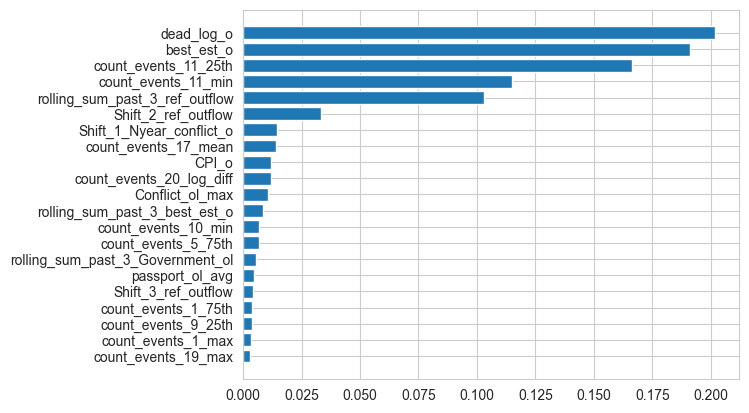

In [109]:
importances = gb_pipe.named_steps['gb'].feature_importances_

# Get column names from ColumnTransformer object
column_names = list(gb_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols


# Map feature importances to column names
feature_importances = dict(zip(column_names, importances))

indexes = model_helpers.feature_imp_more(feature_importances)


Even though the GDELT features are not improving the overall relative RMSE, they are picked up by the model as very relevant.

In [110]:
ind = X_test[["iso_o", "year"]]
ind["y_pred_aug_gdelt"]=y_pred

predictions_merged = pd.merge(predictions_merged, ind, on=["iso_o", "year"], how="left")


# Compute RMSE for each row
predictions_merged['GB_error_aug_gdelt'] = np.sqrt((predictions_merged['y_test'] - predictions_merged['y_pred_aug_gdelt']) ** 2)



C:\Users\danid\AppData\Local\Temp\ipykernel_41716\980089077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ind["y_pred_aug_gdelt"]=y_pred


### Rolling window GDELT

In [149]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(aug_gdelt, 'target', test_time_start, test_time_end, 'year')

In [112]:
mse_gdelt_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):

    gb_pipe.fit(X_train, y_train)

    y_pred = gb_pipe.predict(X_test)
    y_pred = np.clip(y_pred, 0, None)
    mse_gdelt_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_gdelt_dict[year] = mse_gdelt_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows - migration covariates: " + str(mse_gdelt_year))
    print("Relative RMSE to Naive predictions: " + str(mse_gdelt_year / mse_naive_dict[year]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_gdelt_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_gdelt = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE outflows - migration covariates: 96496.40869705015
Relative RMSE to Naive predictions: 0.5175244794544747
*********
Year: 2019
X_train uses data until: 2018
RMSE outflows - migration covariates: 32800.64315196844
Relative RMSE to Naive predictions: 0.4134582305457888
*********
Year: 2020
X_train uses data until: 2019
RMSE outflows - migration covariates: 25349.487578085707
Relative RMSE to Naive predictions: 0.3659469135267249
*********
Year: 2021
X_train uses data until: 2020
RMSE outflows - migration covariates: 44246.21488010667
Relative RMSE to Naive predictions: 2.150760245352594


In [113]:
predictions_merged = pd.merge(predictions_merged, predictions_df_gdelt, on=["iso_o", "year"], how="left")
mean_squared_error(y_true=predictions_merged.y_test, y_pred=predictions_merged.y_pred_gdelt_rw, squared=False)/mse_naive

0.7641137224348311

With log transformation of Y:

In [114]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(aug_gdelt.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])

X_train, X_test, y_train, y_test = model_helpers.train_test_split(aug_gdelt, 'target', test_time_start, test_time_end, 'year')

# Add a small constant to handle zero values
epsilon = 1e-8
y_train_log = np.log(y_train + epsilon)

gb_pipe.fit(X_train, y_train_log)

# Predict on test set and transform back to original scale
y_pred_log = gb_pipe.predict(X_test)
y_pred = np.exp(y_pred_log) 




mse_aug_gdelt = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends + UNHCR covariates + Migration + GDELT: " + str(mse_aug_gdelt))
print("Relative RMSE to Naive predictions: " + str(mse_aug_gdelt / mse_naive))

RMSE outflows - GTrends + UNHCR covariates + Migration + GDELT: 31508.06989379101
Relative RMSE to Naive predictions: 0.2929184732126549


With rolling window:

In [154]:
mse_gdelt_log_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 
    
    mse_gdelt_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_gdelt_log_dict[year] = mse_gdelt_log_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows - migration + gdelt covariates: " + str(mse_gdelt_log_year))
    print("Relative RMSE to Naive predictions: " + str(mse_gdelt_log_year / mse_naive_dict[year]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_gdelt_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_gdelt_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE outflows - migration + gdelt covariates: 21426.279896355205
Relative RMSE to Naive predictions: 0.11491230087971217
*********
Year: 2019
X_train uses data until: 2018
RMSE outflows - migration + gdelt covariates: 32644.8342008692
Relative RMSE to Naive predictions: 0.4114942296289098
*********
Year: 2020
X_train uses data until: 2019
RMSE outflows - migration + gdelt covariates: 42112.65782814893
Relative RMSE to Naive predictions: 0.6079411706113055
*********
Year: 2021
X_train uses data until: 2020
RMSE outflows - migration + gdelt covariates: 14071.942447600655
Relative RMSE to Naive predictions: 0.6840217739121598


In [158]:
predictions_merged = pd.merge(predictions_merged, predictions_df_gdelt_log, on=["iso_o", "year"], how="left")
mean_squared_error(y_true=predictions_merged.y_test, y_pred=predictions_merged.y_pred_gdelt_log_rw, squared=False)/mse_naive

0.605590024632172

In [159]:
# Combine dictionaries into a single dictionary
combined_dict = {
    'Naive': mse_naive_dict,
    'UNHCR': mse_unhcr_dict,
    'GTrends': mse_gtrends_dict,
    'Augmented: UNHCR+GTrends': mse_aug_dict,
    'Augmented 2: Aug + Migration': mse_mig_dict,
    'Augmented 3: Aug2 + GDELT': mse_gdelt_dict,
    'Aug2 (log)': mse_mig_log_dict,
    'Aug3 (log)': mse_gdelt_log_dict
}

# Create a DataFrame from the combined dictionary
mse_df = pd.DataFrame.from_dict(combined_dict)

# Print the DataFrame
mse_df




,Naive,UNHCR,GTrends,Augmented: UNHCR+GTrends,Augmented 2: Aug + Migration,Augmented 3: Aug2 + GDELT,Aug2 (log),Aug3 (log)
2018,186457.670174,98188.681785,112325.736926,82681.415263,82786.773135,96496.408697,95769.236718,21426.279896
2019,79332.422791,78348.091231,26028.349919,47285.518170,50011.346558,32800.643152,31497.831112,32644.834201
2020,69270.942427,69703.579500,36608.023175,23973.963452,25833.074291,25349.487578,39581.192259,42112.657828
2021,20572.360390,14913.676526,38967.042080,55143.872822,72970.328059,44246.214880,14988.709193,14071.942448


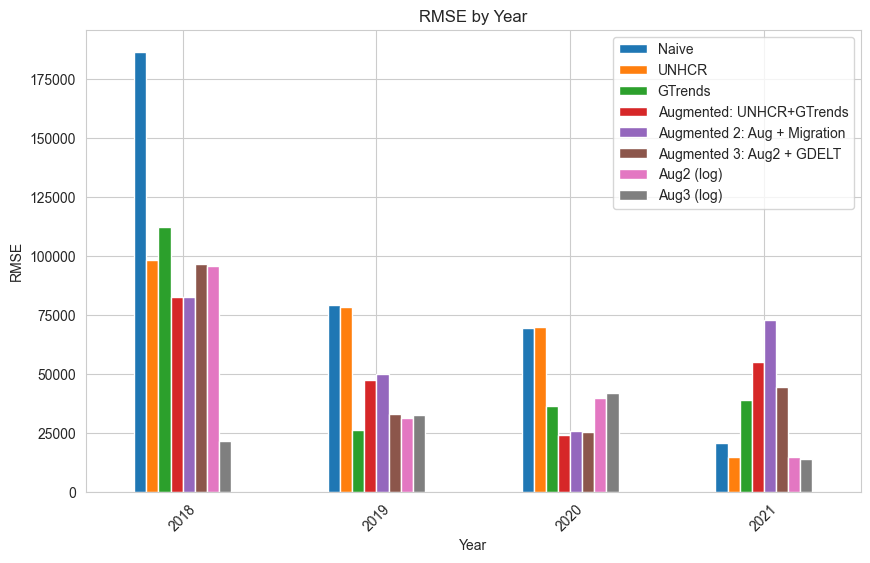

In [160]:
# Reset the index
mse_df_reset = mse_df.reset_index()

# Plotting the bar chart
mse_df_reset.plot.bar(x='index', figsize=(10, 6))

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('RMSE')
plt.title('RMSE by Year')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()


In [161]:
relative_mse = mse_df.div(mse_df['Naive'], axis=0)

In [162]:
relative_mse

,Naive,UNHCR,GTrends,Augmented: UNHCR+GTrends,Augmented 2: Aug + Migration,Augmented 3: Aug2 + GDELT,Aug2 (log),Aug3 (log)
2018,1.0,0.526600,0.602420,0.443433,0.443998,0.517524,0.513625,0.114912
2019,1.0,0.987592,0.328092,0.596043,0.630402,0.413458,0.397036,0.411494
2020,1.0,1.006246,0.528476,0.346090,0.372928,0.365947,0.571397,0.607941
2021,1.0,0.724938,1.894145,2.680484,3.547008,2.150760,0.728585,0.684022


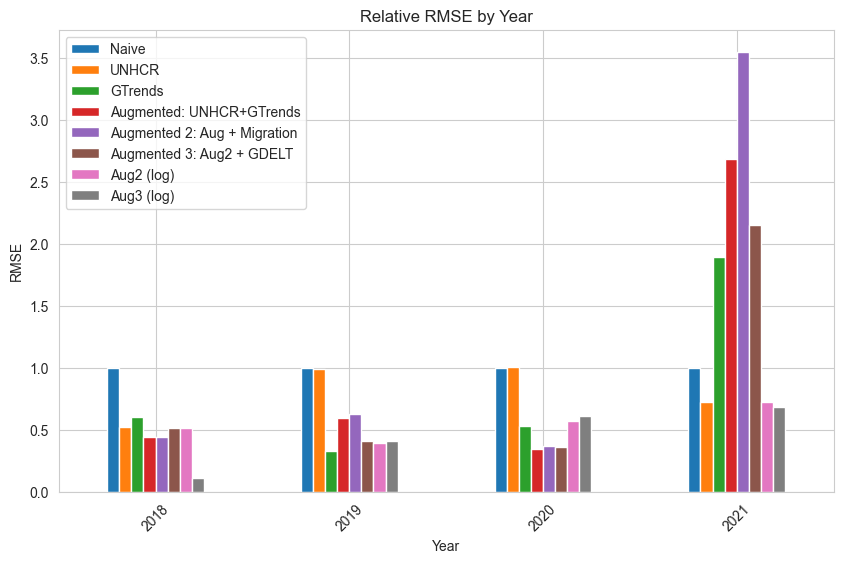

In [163]:
# Reset the index
relative_mse_reset = relative_mse.reset_index()

# Plotting the bar chart
relative_mse_reset.plot.bar(x='index', figsize=(10, 6))

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('RMSE')
plt.title('Relative RMSE by Year')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [165]:
predictions_merged.columns

Index(['iso_o', 'year', 'y_test', 'y_naive', 'y_unhcr', 'y_pred_tw',
       'naive_error', 'RF_error_trends', 'y_pred_aug', 'GB_error_aug',
       'GB_error_unhcr', 'actual_range', 'y_pred_unhcr_rw',
       'y_pred_gtrends_rw', 'y_pred_aug_rw', 'GB_error_unhcr_rw',
       'GB_error_aug_rw', 'y_pred_aug_mig', 'GB_error_aug_mig',
       'y_pred_aug_gdelt', 'GB_error_aug_gdelt', 'y_pred_gdelt_rw',
       'y_pred_gdelt_log_rw'],
      dtype='object')

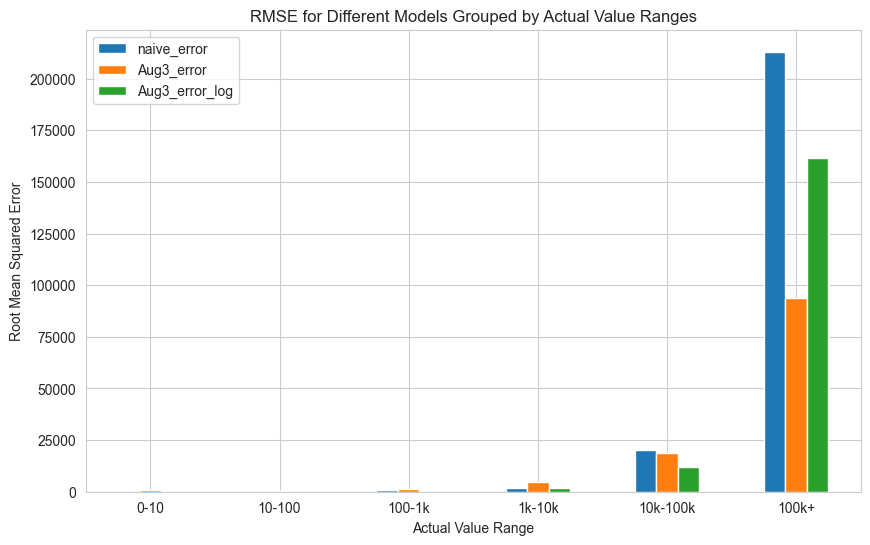

In [170]:
# Compute mean RMSE for each group

predictions_merged['Aug3_error_log'] = np.sqrt((predictions_merged['y_test'] - predictions_merged['y_pred_gdelt_log_rw']) ** 2)

predictions_merged['Aug3_error'] = np.sqrt((predictions_merged['y_test'] - predictions_merged['y_pred_gdelt_rw']) ** 2)

# grouped_errors = predictions_merged[['naive_error', 'GB_error_unhcr_rw', 'GB_error_aug_rw', 'actual_range']].groupby('actual_range').mean()
grouped_errors = predictions_merged[['naive_error', 'Aug3_error', 'Aug3_error_log', 'actual_range']].groupby('actual_range').mean()

grouped_errors.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
# plt.yscale('log')
plt.legend()
plt.show()

How biased are the estimates? Aug 3 + log

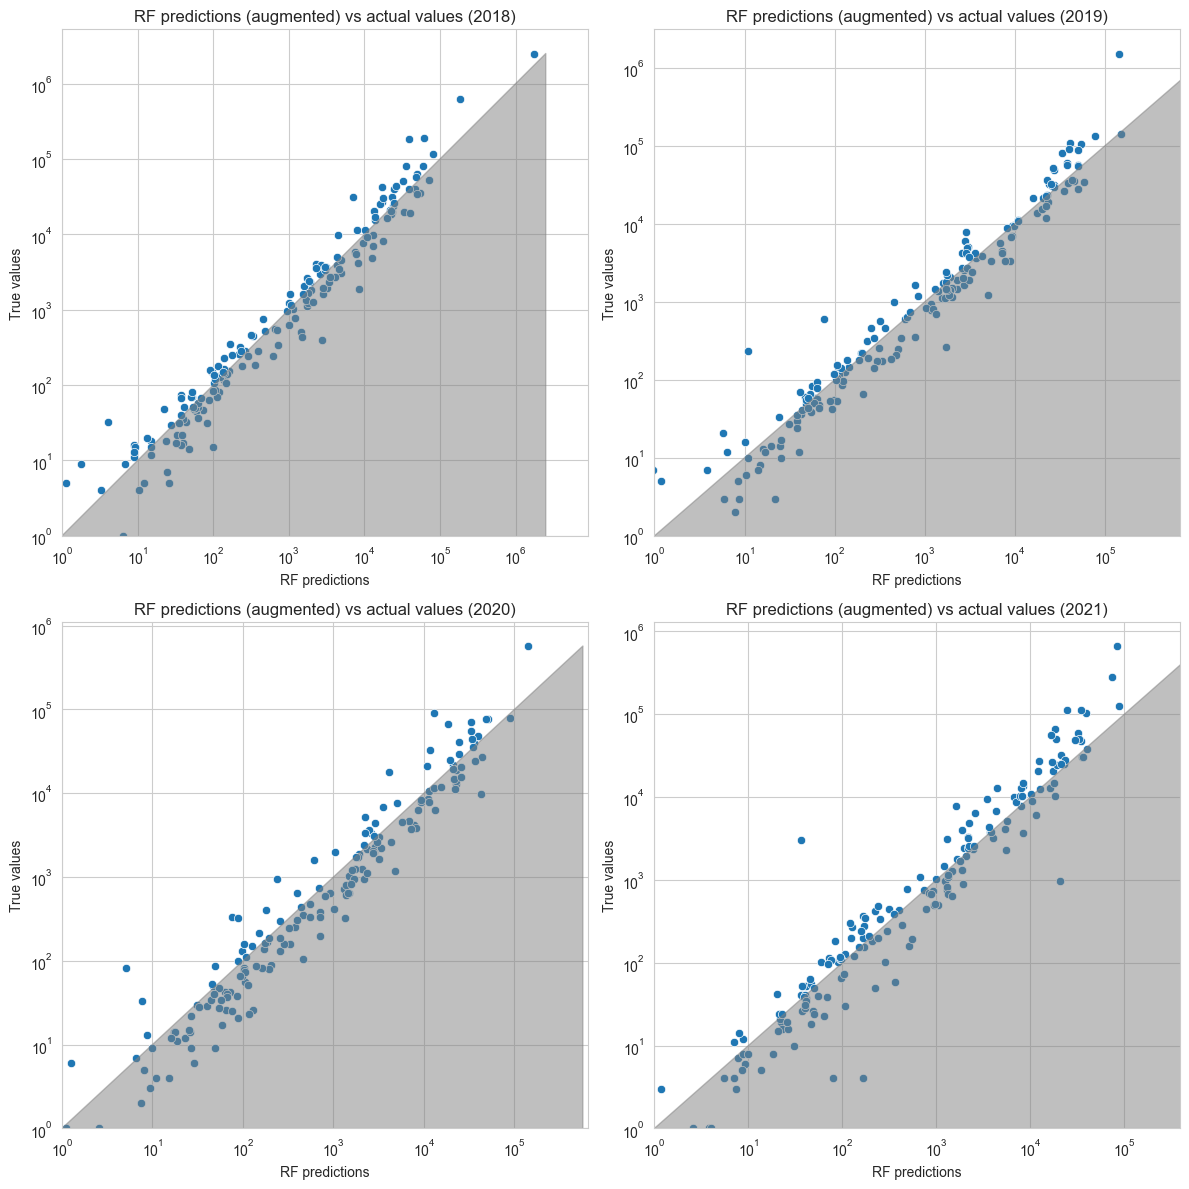

In [172]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

years = predictions_merged['year'].unique()

for i, year in enumerate(years):
    ax = axes.flatten()[i]
    data = predictions_merged[predictions_merged['year'] == year]
    
    # Plot the scatterplot for the current year
    sns.scatterplot(data=data, x='y_pred_gdelt_log_rw', y='y_test', ax=ax)
    ax.set_xlabel('RF predictions')
    ax.set_ylabel('True values')
    ax.set_title(f'RF predictions (augmented) vs actual values ({year})')
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Set the lower limits of the x and y axes to 1
    ax.set_xlim(left=1)
    ax.set_ylim(bottom=1)

    # Get the maximum value from x and y axes
    max_val = max(data['y_test'].max(), data['y_pred_gdelt_log_rw'].max())

    # Create the diagonal line coordinates
    diagonal_line = np.linspace(0, max_val, 100)

    # Fill the area below the diagonal line in the current subplot
    ax.fill_between(diagonal_line, 0, diagonal_line,
                      where=diagonal_line >= 0,
                      interpolate=True,
                      color='gray', alpha=0.5)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


Comparing aug 3 (levels/logs)

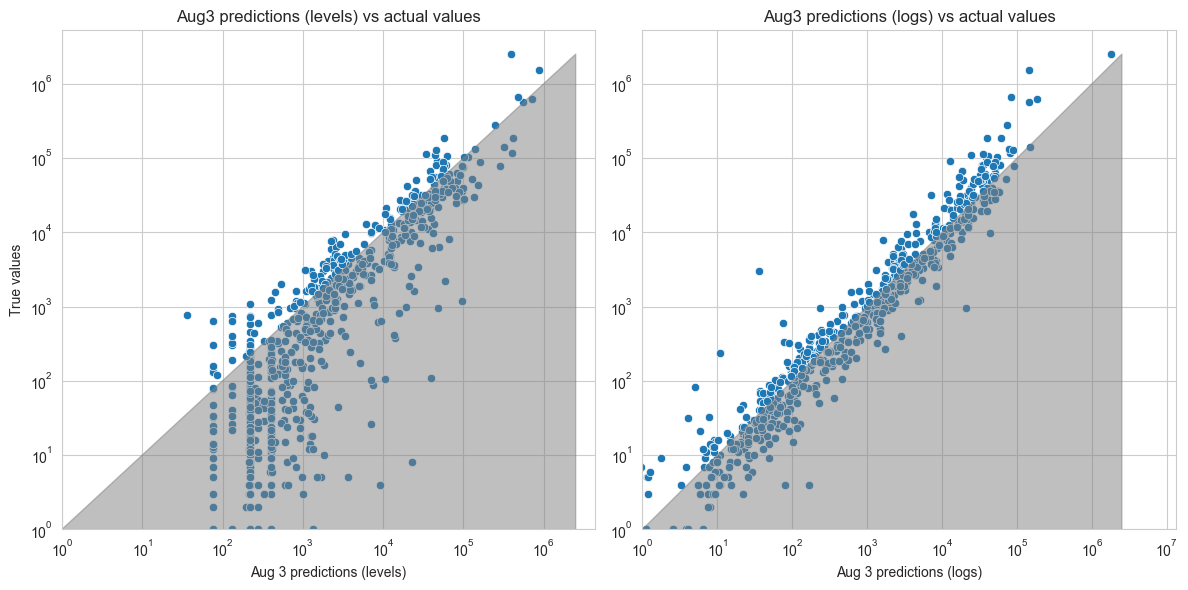

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first subplot
sns.scatterplot(data=predictions_merged, x='y_pred_gdelt_rw', y='y_test', ax=axes[0])
axes[0].set_xlabel('Aug 3 predictions (levels)')
axes[0].set_ylabel('True values')
axes[0].set_title('Aug3 predictions (levels) vs actual values')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# Get the maximum value from x and y axes
max_val = max(predictions_merged['y_test'].max(), predictions_merged['y_pred_gdelt_rw'].max())

# Create the diagonal line coordinates
diagonal_line = np.linspace(0, max_val, 100)

# Fill the area below the diagonal line in the second subplot
axes[0].fill_between(diagonal_line, 0, diagonal_line,
                      where=diagonal_line >= 0,
                      interpolate=True,
                      color='gray', alpha=0.5)
axes[0].set_xlim(left=1)
axes[0].set_ylim(bottom=1)

# Plot the second subplot (modify the column names accordingly)
sns.scatterplot(data=predictions_merged, x='y_pred_gdelt_log_rw', y='y_test', ax=axes[1])
axes[1].set_xlabel('Aug 3 predictions (logs)')
axes[1].set_ylabel('')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('Aug3 predictions (logs) vs actual values')

# Get the maximum value from x and y axes
max_val = max(predictions_merged['y_test'].max(), predictions_merged['y_pred_gdelt_log_rw'].max())

# Create the diagonal line coordinates
diagonal_line = np.linspace(0, max_val, 100)

# Fill the area below the diagonal line in the second subplot
axes[1].fill_between(diagonal_line, 0, diagonal_line,
                      where=diagonal_line >= 0,
                      interpolate=True,
                      color='gray', alpha=0.5)
axes[1].set_xlim(left=1)
axes[1].set_ylim(bottom=1)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


In [177]:
predictions_final = predictions_merged[["year", "iso_o", "y_naive", "y_pred_gdelt_log_rw"]]

In [178]:
predictions_final.to_csv("../../best predictions/outflows_best_rw (30-6).csv", index=False)

### Appendix

Adding COVID data (restrictions on international flights)

In [130]:
covid = pd.read_csv(path + "international-travel-covid.csv").drop(columns=["Entity"]).rename(columns={"Code":"iso_o"})
covid["Day"] = pd.to_datetime(covid["Day"])
covid["year"] = covid["Day"].dt.year
covid = covid.groupby(['iso_o','year'])[['international_travel_controls']].agg(agg_year)
covid = split_df(covid)

covid = covid.reset_index()
covid.head()

,iso_o,year,international_travel_controls_min,international_travel_controls_25th,international_travel_controls_mean,international_travel_controls_75th,international_travel_controls_max,international_travel_controls_log_diff
0,ABW,2020,0.0,1.0,3.0,3.0,4.0,0.001899
1,ABW,2021,1.0,1.0,1.0,3.0,3.0,0.000000
2,ABW,2022,0.0,0.0,0.0,0.0,1.0,-0.001904
3,AFG,2020,0.0,1.0,1.0,3.0,3.0,0.001899
4,AFG,2021,1.0,1.0,2.0,2.0,4.0,0.001114


In [131]:
aug_covid = pd.merge(aug_gdelt, covid, on=["iso_o", "year"], how="left")
aug_covid = aug_covid.fillna(0)
print(aug_covid.shape)
aug_covid.head()

(3332, 797)


,iso_o_continent,iso_o,year,pop_o,CPI_o,GDP_PP_o,GDP_PPP_o,island_o,area_o,landlocked_o,...,count_events_20_mean,count_events_20_75th,count_events_20_max,count_events_20_log_diff,international_travel_controls_min,international_travel_controls_25th,international_travel_controls_mean,international_travel_controls_75th,international_travel_controls_max,international_travel_controls_log_diff
0,NA,ABW,2005,0.098,3.787,37910.69,0.005,1,193.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NA,ABW,2006,0.099,2.510,37655.07,0.005,1,193.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NA,ABW,2007,0.100,9.920,38530.06,0.005,1,193.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NA,ABW,2008,0.101,-1.859,38939.16,0.005,1,193.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NA,ABW,2009,0.102,6.777,34159.06,0.004,1,193.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Predictions with rolling window + log transformation

In [132]:

# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_o_continent','Shift_1_typeOfViolence_o', 'typeOfViolence_o']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(aug_covid.columns) - set(binary_cols  + ['year', 'target']))

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

gb_pipe = Pipeline([('preprocessing', transform_cols),
                    ('gb', GradientBoostingRegressor(random_state=SEED))])

In [133]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(aug_covid, 'target', test_time_start, test_time_end, 'year')

In [134]:
mse_covid_log_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    gb_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = gb_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 
    
    mse_covid_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_covid_log_dict[year] = mse_covid_log_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE outflows - migration covariates: " + str(mse_covid_log_year))
    print("Relative RMSE to Naive predictions: " + str(mse_covid_log_year / mse_naive_dict[year]))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_covid_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_covid_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE outflows - migration covariates: 56422.19766175322
Relative RMSE to Naive predictions: 0.302600572071538
*********
Year: 2019
X_train uses data until: 2018
RMSE outflows - migration covariates: 29945.938890569814
Relative RMSE to Naive predictions: 0.37747415038062393
*********
Year: 2020
X_train uses data until: 2019
RMSE outflows - migration covariates: 42203.32324026127
Relative RMSE to Naive predictions: 0.6092500226196128
*********
Year: 2021
X_train uses data until: 2020
RMSE outflows - migration covariates: 14071.942447599842
Relative RMSE to Naive predictions: 0.6840217739121203


COVID data doesn't improve results